# Data augmentation

FMML Module 1, Lab 3<br>
 Module Coordinator: Thrupthi Ann John thrupthi.ann@research.iiit.ac.in <br>
 Release date: 18 October 2021 <br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [1]:
# augmentation : when we have a small data set;improve accuracy;as data is expensive
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist # mnist: handwritten digits
# set randomseed
rng = np.random.default_rng(seed=42) # seed: in a specific range so that all the values are uniform
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically. 

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation. 

In [2]:
#loading the dataset
#splitting the data into train and test
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255
# train_x and train_y are very wide, so we take a small sample
train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# not extracting the features
train_X.shape

(50, 28, 28)

In [4]:
test_X.shape

(10000, 28, 28)

Let us borrow a few functions from the previous labs:

In [5]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here 
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares; sum along the axis
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label 

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data 
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28) # reshapening the data
  testdata = testdata.reshape(-1,28*28) #reshape: to make the vector as 1D, to flatten
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel) # gt: groundtruth

In [6]:
test_X.reshape(-1, 28*28).shape

(10000, 784)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [7]:
# accuracy on test set without argumentation
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))# this accuracy can be increased by argumentation.
# in mnist we wont flip bcz as the digit is flipped, the num changes

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. 

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this. 

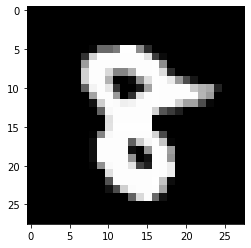

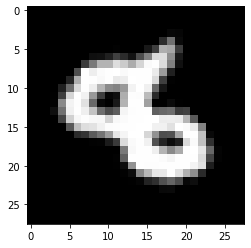

In [8]:
# we should divide the set into validation & test set
plt.imshow(train_X[2], cmap='gray') 
plt.show()
plt.imshow(rotate(train_X[2],45), cmap='gray')# rotating the digit by 45

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [9]:
def augRotate(sample, angleconstraint):#rotate image by a random angle
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple. 

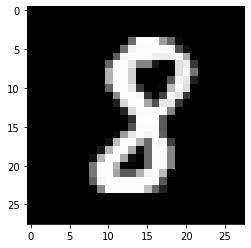

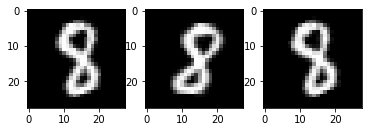

In [10]:
sample = train_X[20]# checking the 21st data point
angleconstraint = 70 3=# a slight variation causes a change in pixels
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [12]:
# hyperparameters
angleconstraint = 60
naugmentations = 5 # each sample is argumented 5 times
# augdata & auglabel have original data& labels
# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy on argumented data set
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6667


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [13]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6655
Accuracy after rotation augmentation constrained by  20  is  0.6717
Accuracy after rotation augmentation constrained by  30  is  0.6779
Accuracy after rotation augmentation constrained by  40  is  0.6741
Accuracy after rotation augmentation constrained by  50  is  0.6746
Accuracy after rotation augmentation constrained by  60  is  0.6678
Accuracy after rotation augmentation constrained by  70  is  0.653
Accuracy after rotation augmentation constrained by  80  is  0.6489
Accuracy after rotation augmentation constrained by  90  is  0.6487


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

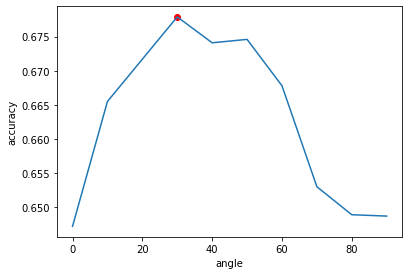

In [14]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')
# in graph accuracy increases and then starts decreasing , checking angles by trial & error

Let us try one more augmentation: shear. Here is what this looks like:

In [15]:
def shear(sample, amount):# digit written on elastic sheet and is pulled from either sides
# shear: it keeps one axis constant and the other axis shifted
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # warp(): apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

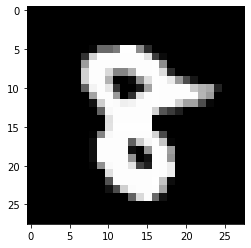

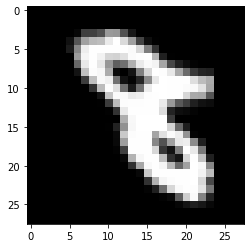

In [16]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [17]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [18]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6178
Accuracy after shear augmentation constrained by  0.4  is  0.6221
Accuracy after shear augmentation constrained by  0.6  is  0.647
Accuracy after shear augmentation constrained by  0.8  is  0.6553
Accuracy after shear augmentation constrained by  1.0  is  0.6498
Accuracy after shear augmentation constrained by  1.2  is  0.6345
Accuracy after shear augmentation constrained by  1.4  is  0.6398
Accuracy after shear augmentation constrained by  1.6  is  0.6499
Accuracy after shear augmentation constrained by  1.8  is  0.6319
Accuracy after shear augmentation constrained by  2.0  is  0.628


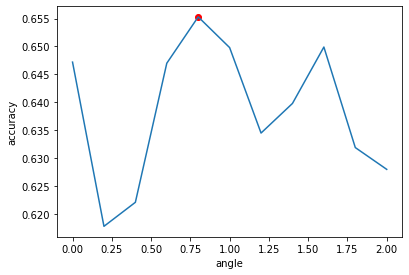

In [19]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters. 

In [20]:
# both rotate & shear
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters. 

In [21]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.5932
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.5909
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.5856
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.5918
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.5841
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6096
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6335
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6156
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6103
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.589
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.5847
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.6049
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6034
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.634
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.59

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

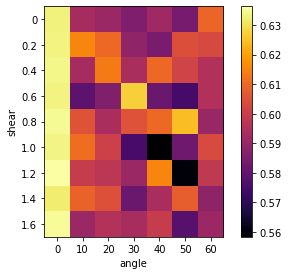

In [22]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno') 
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)
#heat map
# shear is well here
# grid search: combinations of hy[er parameterare checked & see which one is the best
# smote: artificially generate data

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them. 
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
A:angle constraint=30 and shear constraint=1 ; improvement of accuracy is 2%


2. Can you increase the accuracy by increasing the number of augmentations from each sample?
A:yes

3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
A: shifting images, blurring images,
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
A: yes

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch. 

In [23]:
#2. thus accuracy is increased
# hyperparameters
angleconstraint = 60
naugmentations = 15 # each sample is argumented 15 times , increasing num of argumentations

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy on argumented data set
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6754
